# Solve 1-D Dirichlet Problem

$$ -u'' = f \text{ with boundary conditions } u(0) = u(1) = 0$$
The variational problem is to find a function $u(x) \in V$ (i.e. is continuous with piecewise continuous derivative) such that the following holds for all $v \in V$
$$ (u', v') = (f, v) \text{ or } \int_0^1 u'(x)v'(x) dx = \int_0^1 f(x) v(x) dx$$
We construct a finite-dimensional subspace $V_h$ of the space $V$ consisting of piecewise linear functions.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from netgen.meshing import *
# generate a 1D mesh
m = Mesh()
m.dim = 1
nel = 10
pnums = []
for i in range(nel+1):
    pnums.append (m.Add (MeshPoint (Pnt(i/nel, 0, 0))))

# add segments
for i in range(nel):
    m.Add (Element1D ([pnums[i],pnums[i+1]], index=1))

m.SetMaterial(1,'material')

# add points
m.Add (Element0D (pnums[0], index=1))
m.Add (Element0D (pnums[nel], index=2))

# set boundary condition names
m.SetBCName(0,'left')
m.SetBCName(1,'right')


('left', 'right')
freedofs:
 0: 01111111110
mat = 
 Row 0:   0: 10
Row 1:   0: -10   1: 20
Row 2:   1: -10   2: 20
Row 3:   2: -10   3: 20
Row 4:   3: -10   4: 20
Row 5:   4: -10   5: 20
Row 6:   5: -10   6: 20
Row 7:   6: -10   7: 20
Row 8:   7: -10   8: 20
Row 9:   8: -10   9: 20
Row 10:   9: -10   10: 10

rhs = 
     0.05
     0.1
     0.1
     0.1
     0.1
     0.1
     0.1
     0.1
     0.1
     0.1
    0.05


sol =
        0
   0.045
    0.08
   0.105
    0.12
   0.125
    0.12
   0.105
    0.08
   0.045
       0




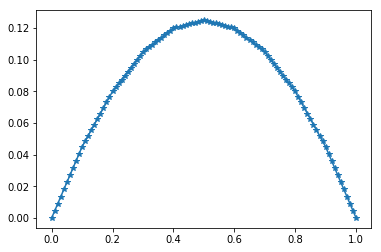

In [4]:
import ngsolve
from ngsolve import *

ngsmesh = ngsolve.Mesh(m)
print(ngsmesh.GetBoundaries())

# H1 is the 'Sobolev Space' of square integrable functions with square integrable weak derivatives.
# Order=1 means that we are approximating by piecewise linear functions.
# Order=2 would mean we are approximating by piecewise quadratic functions and so on.
# Specify Dirichlet (essential) boundary conditions
fes = H1(ngsmesh, order=1, dirichlet='left|right')

print ("freedofs:\n", fes.FreeDofs())

# Forcing function (given)
f = CoefficientFunction(1)  # a coefficient function  (we could just use f = 1)

# Try some other forcing functions (note: for the error to be correct below, we need different exact solutions)
#f = x**3
#f = sin(x**2)
#f = IfPos(x-.5,1,-1) 
u = fes.TrialFunction()  # symbolic object
v = fes.TestFunction()   # symbolic object
gfu = GridFunction(fes)  # solution 

#a = BilinearForm(fes, symmetric=True)
a = BilinearForm(fes, symmetric=True)
a += SymbolicBFI(grad(u)*grad(v))  
a.Assemble()
print ("mat = \n", a.mat)

lf = LinearForm(fes)    
lf += SymbolicLFI(f*v)
lf.Assemble()

print ("rhs = \n", lf.vec)

gfu.vec.data = a.mat.Inverse(fes.FreeDofs()) * lf.vec

print ("sol =\n", gfu.vec)

pnts = [i/100 for i in range(101)]
pnts_vals = [ (x,gfu(x)) for x in pnts if ngsmesh.Contains(x)]

pnts,vals = zip(*pnts_vals)
plt.plot(pnts,vals, "-*")
plt.show()


For the 1-D Laplace problem on the interval $[0,1]$ with a uniform partition and $f(x)=1$ (constant) 
We should have the following system (cf. Claes Johnson p. 21)

In [5]:
from numpy import eye, diag, ones
from scipy.linalg import solve
h = 0.1
A = ( 2*eye(9)-diag(ones(8),1)-diag(ones(8),-1) )/h
b = h*ones(9)
uhand = solve(A,b) # hand computed solution

In [6]:
print('mat\n',A)

mat
 [[ 20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.]
 [  0.   0.   0.   0.   0.   0.   0. -10.  20.]]


In [ ]:
print('rhs\n',b)

In [ ]:
print('sol\n',uhand)

Note that the solutions agree, but the matrices and vectors are different.  This is because our hand calculation did not require solving for the known values of u(x) at x=0 and x=1.  NGSolve computes the matrix and right hand side for the more general Neumann problem, hence using all 11 points. The boundary constraints are taken into account when the inverse is computed (FreeDofs()).

We can also solve the problem explicitly.

$$u'' = -1 \implies u' = -x + C_1 \implies u = -\frac{x^2}{2} + C_1 x + C_2$$

But $u(0) = u(1) = 0$.  So $C_2 = 0$ and $C_1 = \frac{1}{2}$ so the final solution is $u(x) = \cfrac{1}{2}(x-x^2)$


In [ ]:
exact = 1/2*(x-x**2)
print ("L2-error:", sqrt (Integrate ( (gfu-exact)*(gfu-exact), ngsmesh)))

# Exercises:

- Compute the elements of the matrix A and vector b by hand.  Do your results match what is shown above?
- Try changing the number of points in the mesh.  What is the effect on the error?  How is the size of the matrix affected?
- Try changing the order of the space to 2.  How is the error affected?  How is the size of the matrix affected?
- Try changing the forcing function f.  To compute the correct error, you will need to solve the differential equation. 